In [57]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import math
%matplotlib inline

In [58]:
with open(r'D:\all_programming\wetting-analysis\DataFiles\2dContourDataGrid0_5.txt', 'r') as file:
    x_vals = {}
    y_vals = {}
    for row in file:

        if row.startswith('Frame: '):
            row = row.strip()
            junk, current_frame = row.split(': ')
            current_frame = int(current_frame) 
            x_vals[current_frame] = []
            y_vals[current_frame] = []

        elif row.startswith('{'):
            row = row.strip()
            row = row.replace(', ', 'ß')
            row = row.replace('} {', 'ß')
            row = row.replace('{', '')
            row = row.replace('}', '')
            broken_row = row.split('ß')

            for i in range(len(broken_row)):
                if i % 2 == 0:
                    x_vals[current_frame].append(float(broken_row[i]))
                elif i % 2 == 1:
                    y_vals[current_frame].append(float(broken_row[i]))
            
            x_vals_polished = {}
            for frame in x_vals.keys():
                min_x = min(x_vals[frame])
                x_vals_polished[frame] = []

                for item in x_vals[frame]:
                    x_vals_polished[frame].append(item + abs(min_x))
            x_vals = x_vals_polished

In [59]:
# Define the objective function
def objective(params, X, Y):
    a, b, y_0, C, x_0 = params
    summation = np.sum(np.abs((1/a**2)*X**2 - 2*x_0/a**2*X + (1/b**2)*Y**2 - 2*y_0/b**2*Y - C))
    return summation


In [60]:
# Define the implicit equation function
def implicit_eq(X, Y, a, b, y_0, C, x_0):
    return (X**2 / a**2) - (2 * x_0 * X / a**2) + (Y**2 / b**2) - (2 * y_0 * Y / b**2) - C

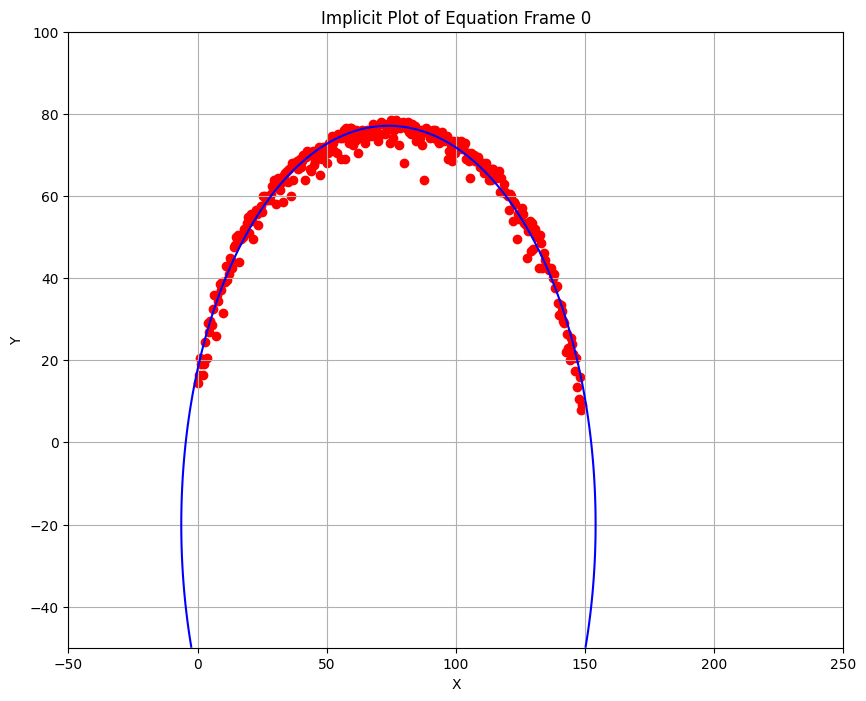

Optimal parameters: a=82.58795306503794, b=100.0, y_0=-20.0, C=0.10248973522123957, x_0=73.88401778592586
Angle: 80.13391356874862


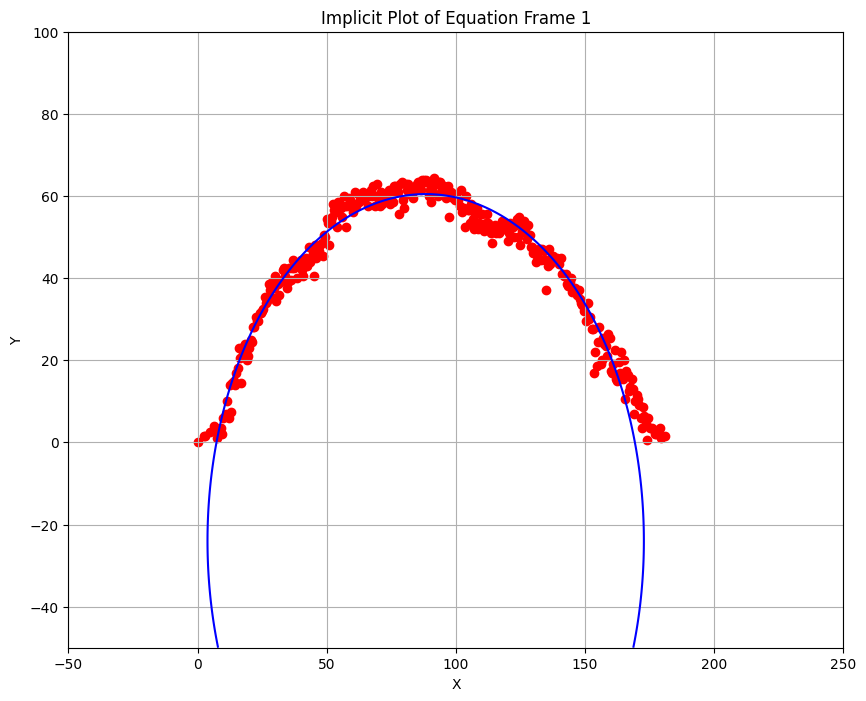

Optimal parameters: a=100.0, b=100.0, y_0=-23.99495145750612, C=-0.12396050334807025, x_0=88.30252534250599
Angle: 73.53219287486499


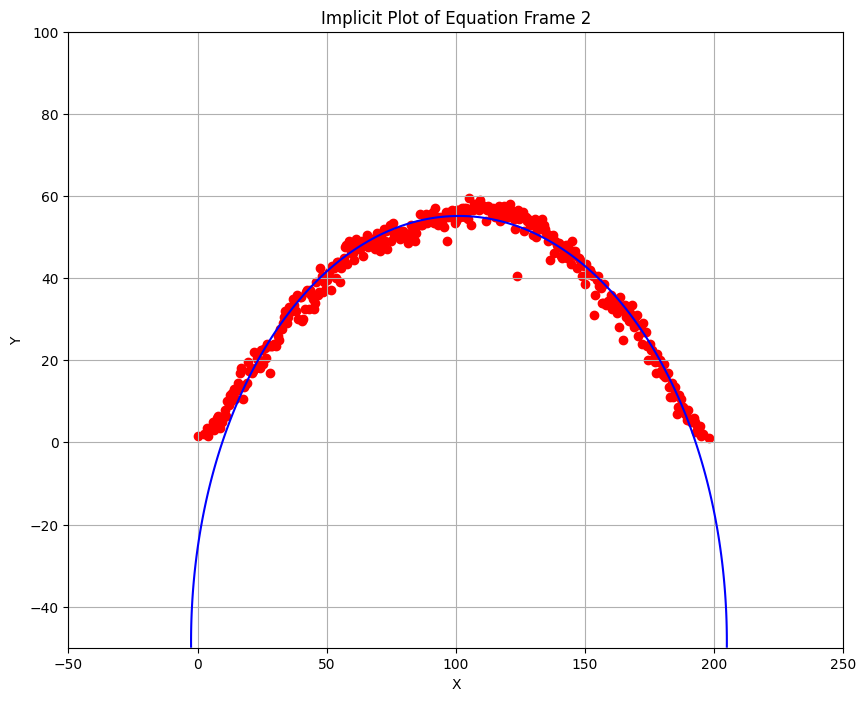

Optimal parameters: a=100.0, b=100.0, y_0=-48.56760236971924, C=-0.18423898758202403, x_0=101.18079049268736
Angle: 62.012854274013655


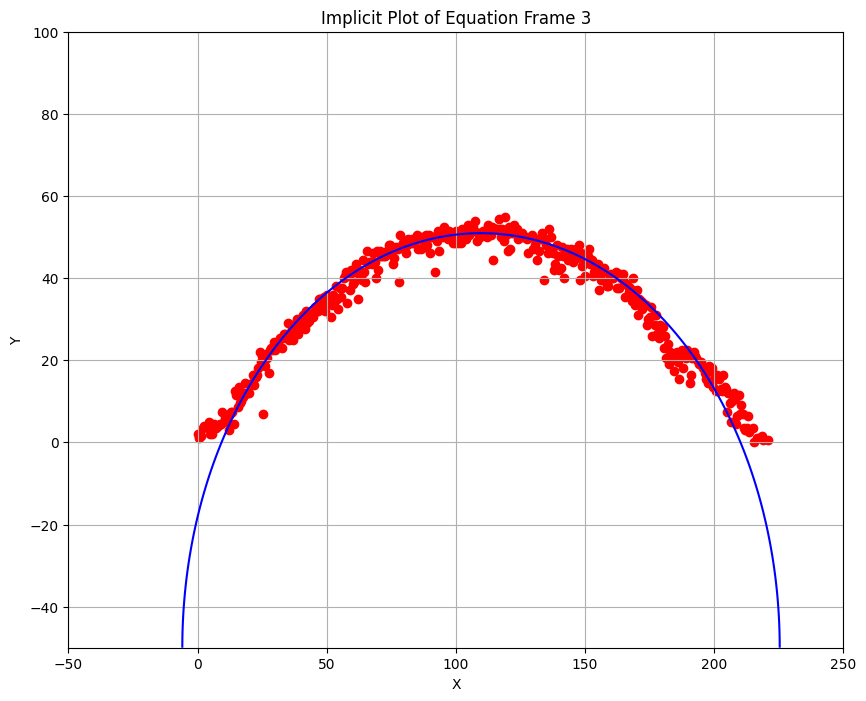

Optimal parameters: a=100.0, b=87.30288573932326, y_0=-50.0, C=-0.19491727892070862, x_0=109.7195292842112
Angle: 56.86982110200177


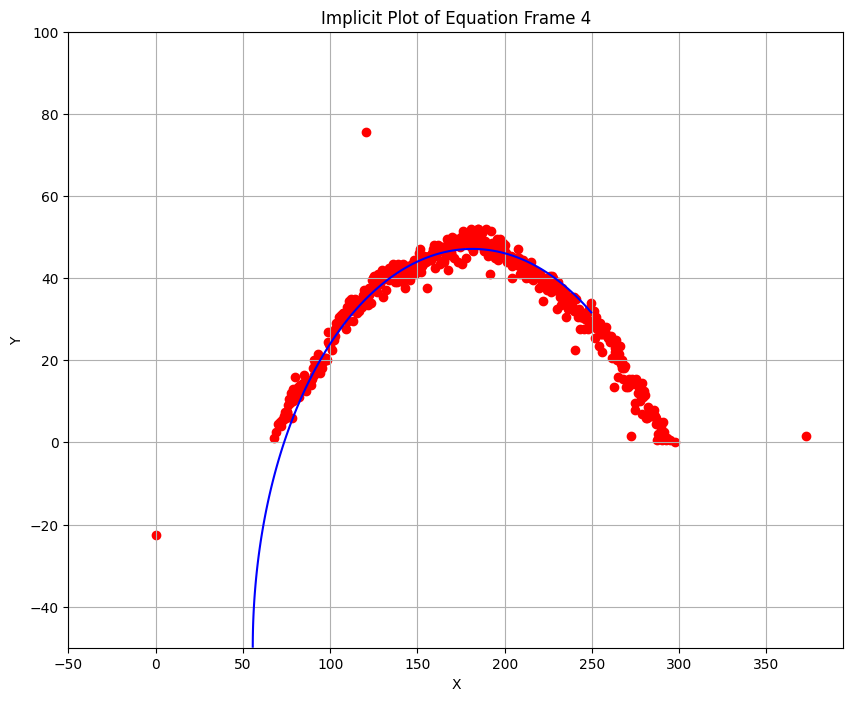

Optimal parameters: a=100.0, b=77.1664342894929, y_0=-50.0, C=-2.1303109213154814, x_0=181.5
Angle: 52.918433395837475


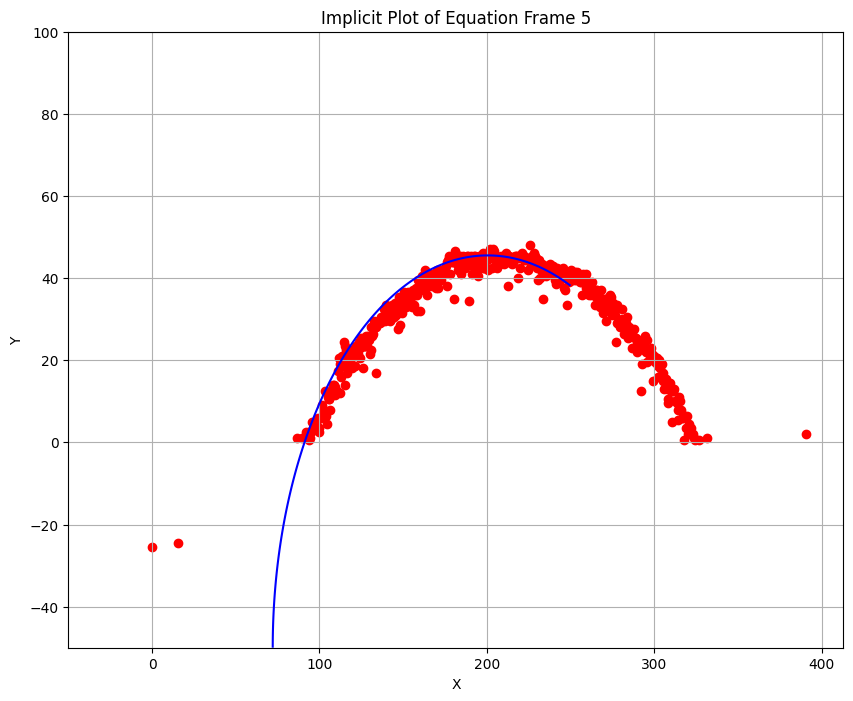

Optimal parameters: a=100.0, b=74.38849343392786, y_0=-50.0, C=-2.8226508786121114, x_0=200.5
Angle: 49.27836551250558


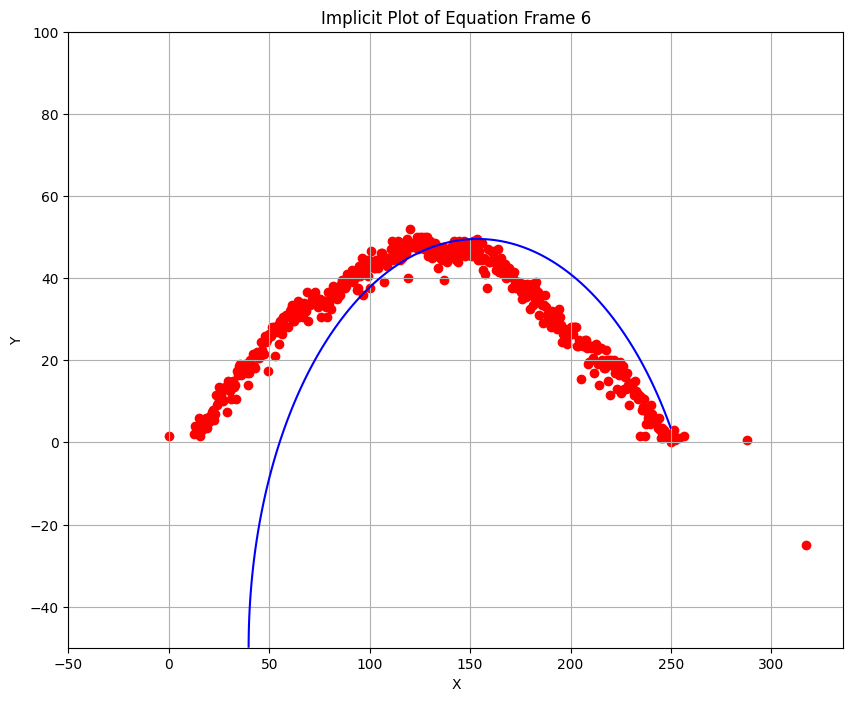

Optimal parameters: a=100.0, b=87.29457519881977, y_0=-50.0, C=-1.3920058130025377, x_0=153.75
Angle: 57.046040482803946


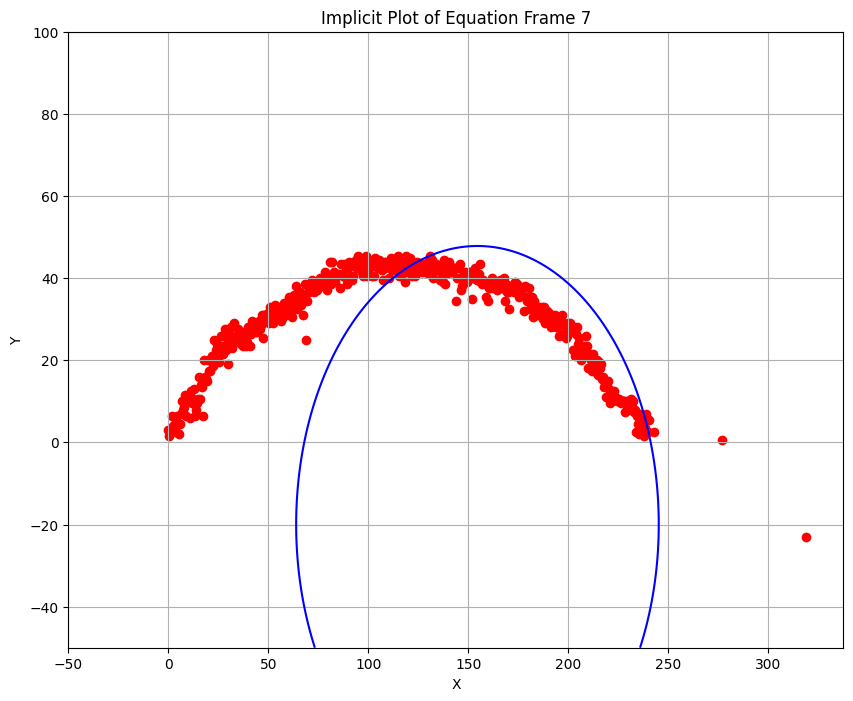

Optimal parameters: a=100.0, b=74.83240358295713, y_0=-20.00012154064882, C=-1.6370259598268864, x_0=154.5
Angle: 68.40655620387683


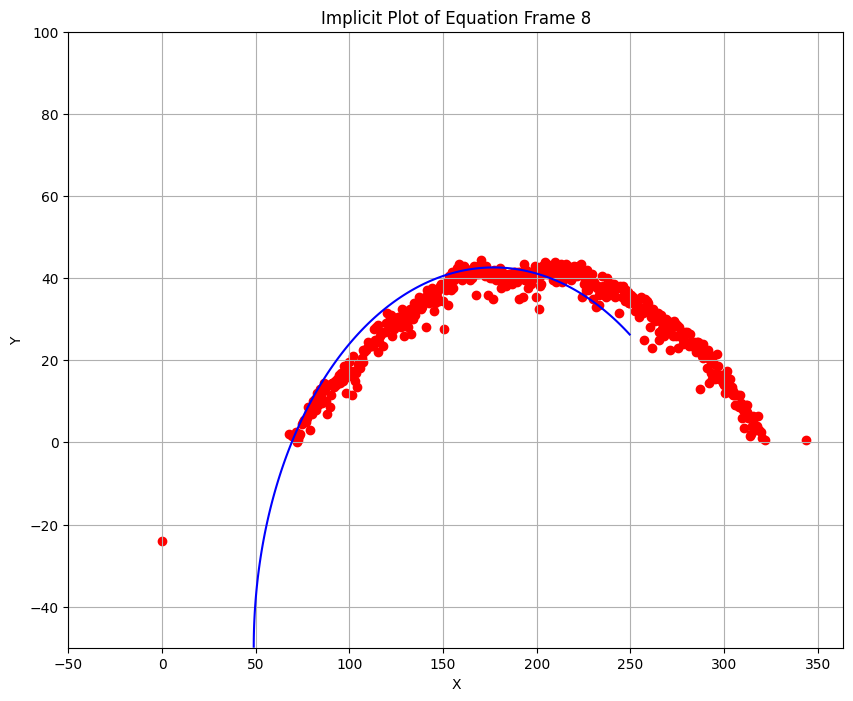

Optimal parameters: a=100.0, b=72.30445453396437, y_0=-50.0, C=-1.9708596066999515, x_0=177.0
Angle: 47.500613285002956


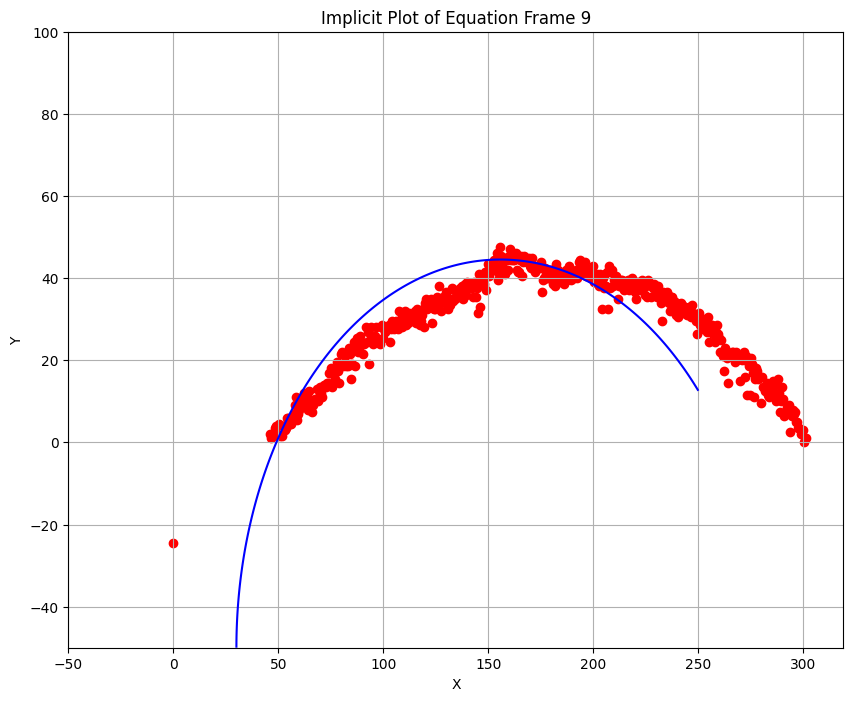

Optimal parameters: a=100.0, b=75.1756627768302, y_0=-50.0, C=-1.2871080124151912, x_0=155.75
Angle: 49.68504933117668


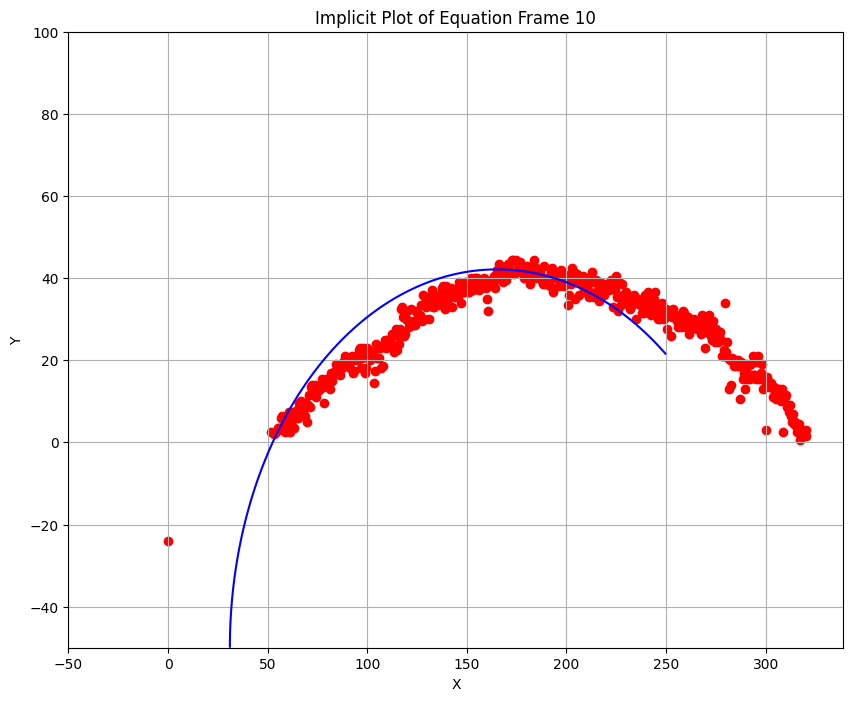

Optimal parameters: a=100.0, b=68.64836472155399, y_0=-50.0, C=-1.46033160538033, x_0=165.25
Angle: 46.098279904882666


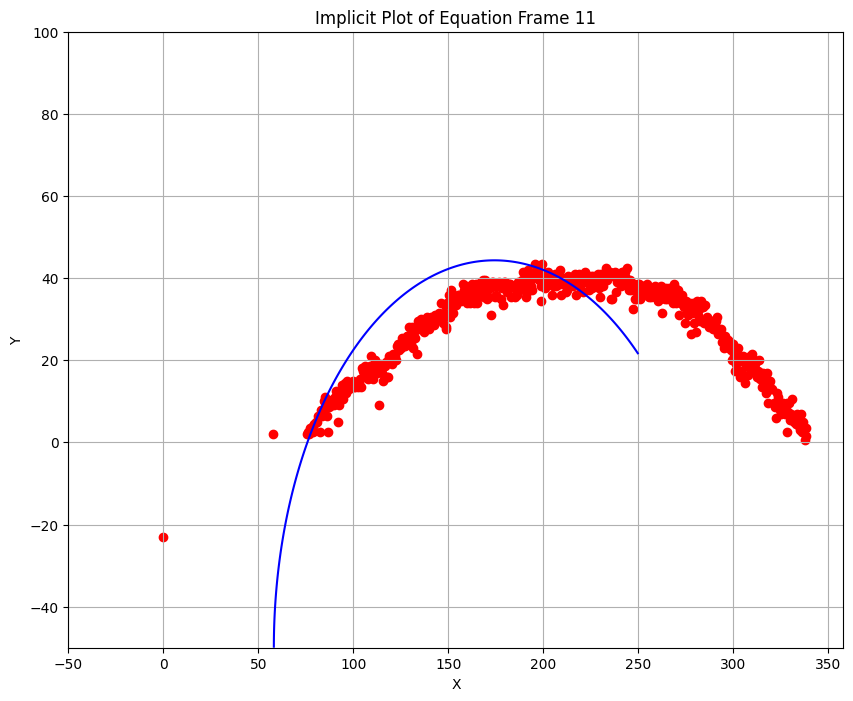

Optimal parameters: a=100.0, b=81.24213102383762, y_0=-50.0, C=-2.0668034107230793, x_0=174.25
Angle: 51.22897761094895


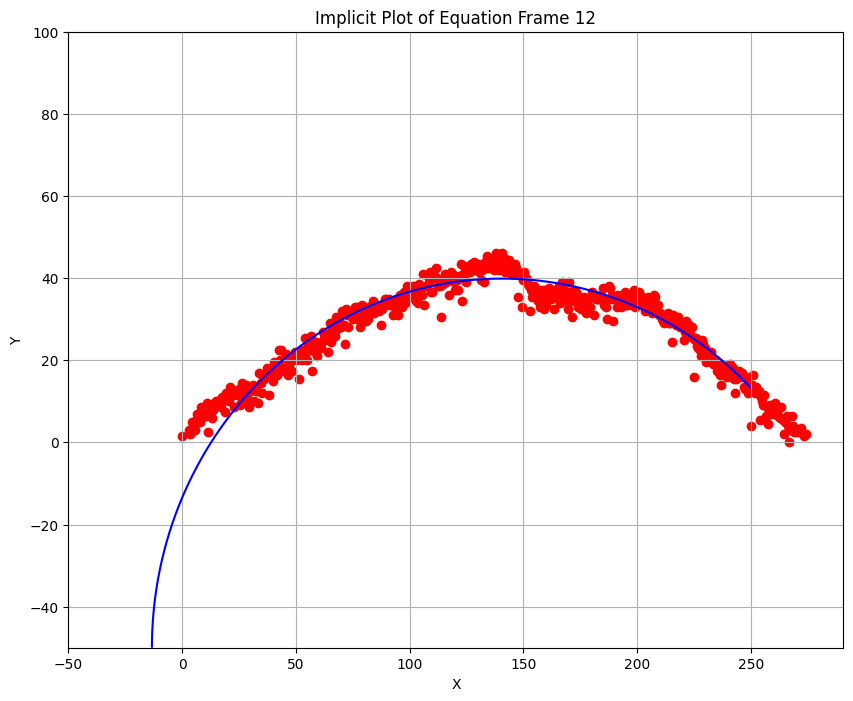

Optimal parameters: a=100.0, b=58.386457365990346, y_0=-50.0, C=-0.34220718799777267, x_0=140.6648498575621
Angle: 41.01654747361692


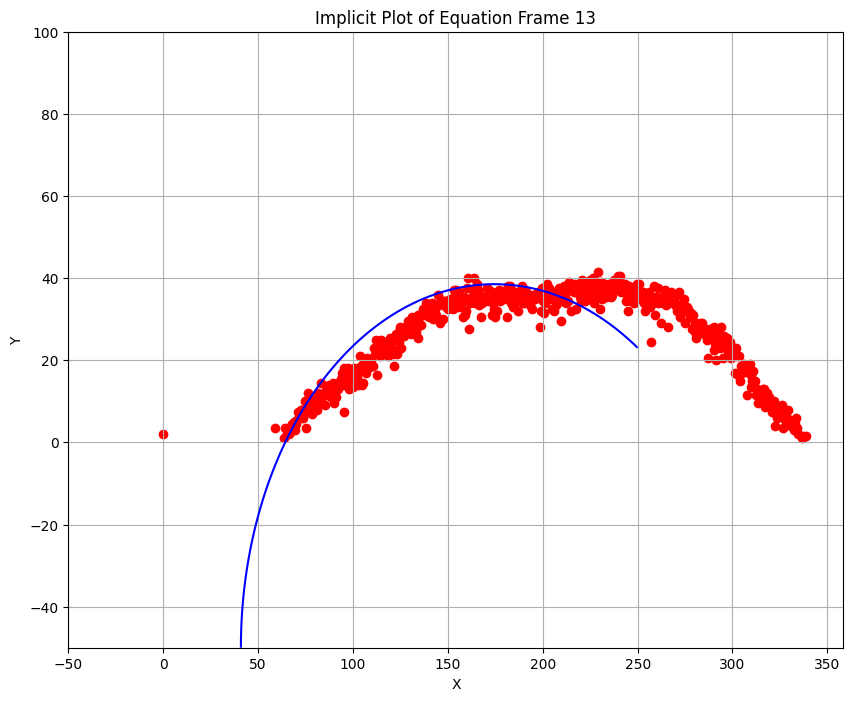

Optimal parameters: a=100.0, b=66.26321527125944, y_0=-50.0, C=-1.8296810204967122, x_0=174.5
Angle: 43.25591068579781


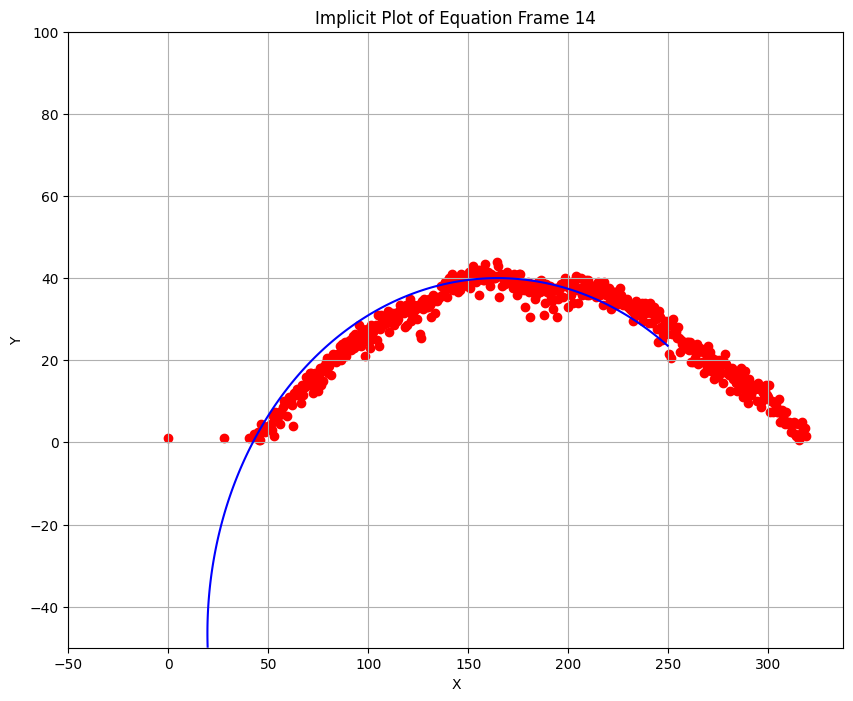

Optimal parameters: a=100.0, b=59.63274397278561, y_0=-46.46468715673056, C=-1.210683429871934, x_0=164.5
Angle: 42.675795890832944


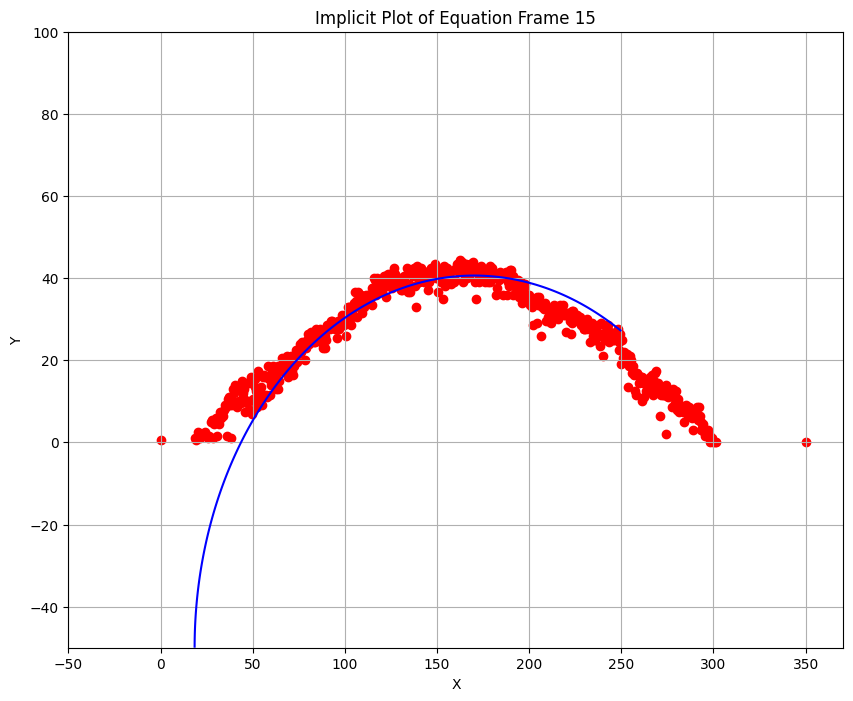

Optimal parameters: a=100.0, b=59.7104014980347, y_0=-50.0, C=-1.2963188046750727, x_0=170.25
Angle: 42.43798893395569


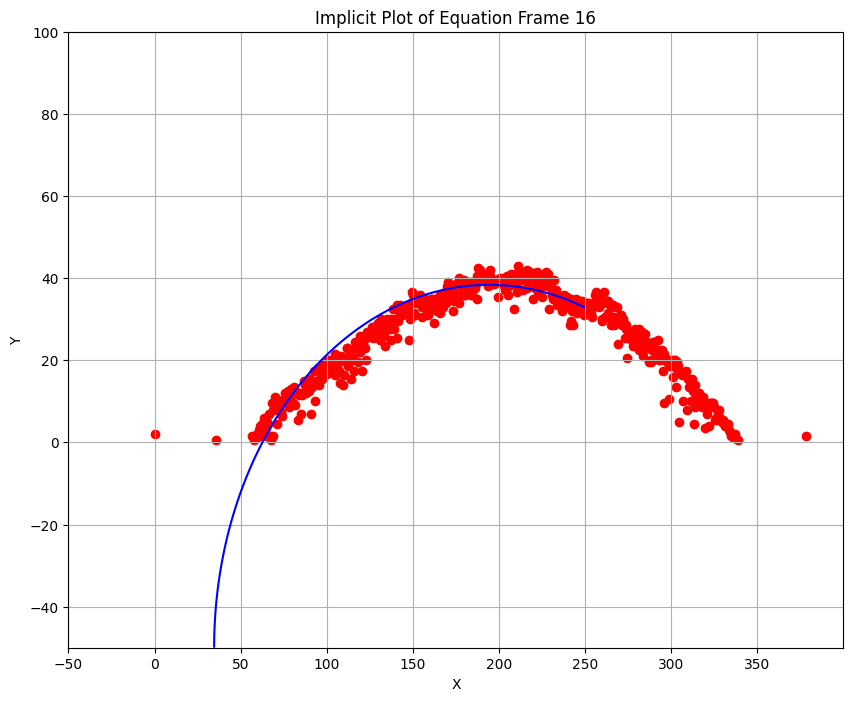

Optimal parameters: a=100.0, b=55.35362818286843, y_0=-50.0, C=-2.04068898319365, x_0=194.25
Angle: 38.35545438595187


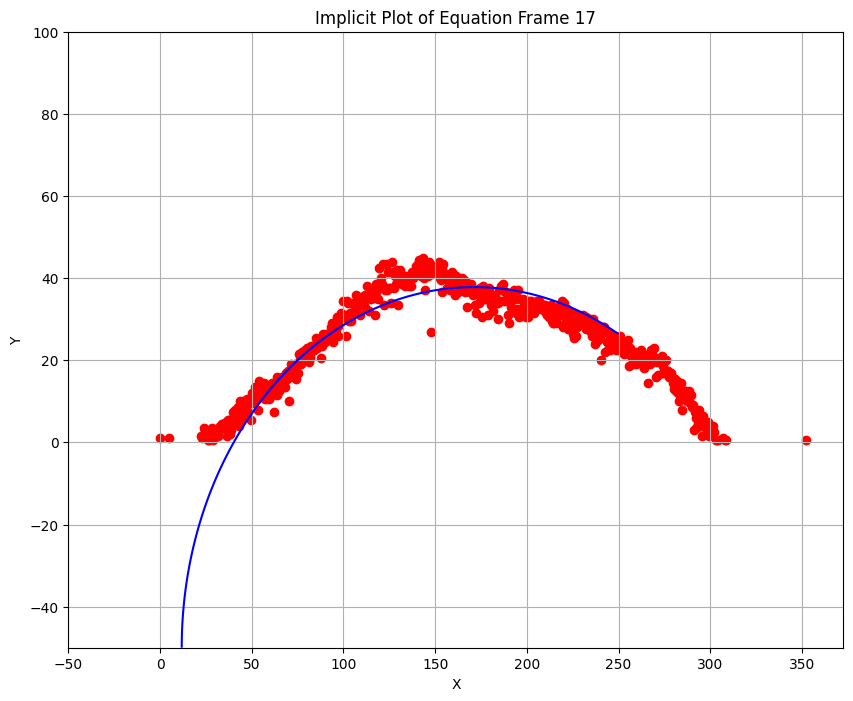

Optimal parameters: a=100.0, b=55.07581257220736, y_0=-50.0, C=-1.2142575992879294, x_0=171.25
Angle: 38.80528487360455


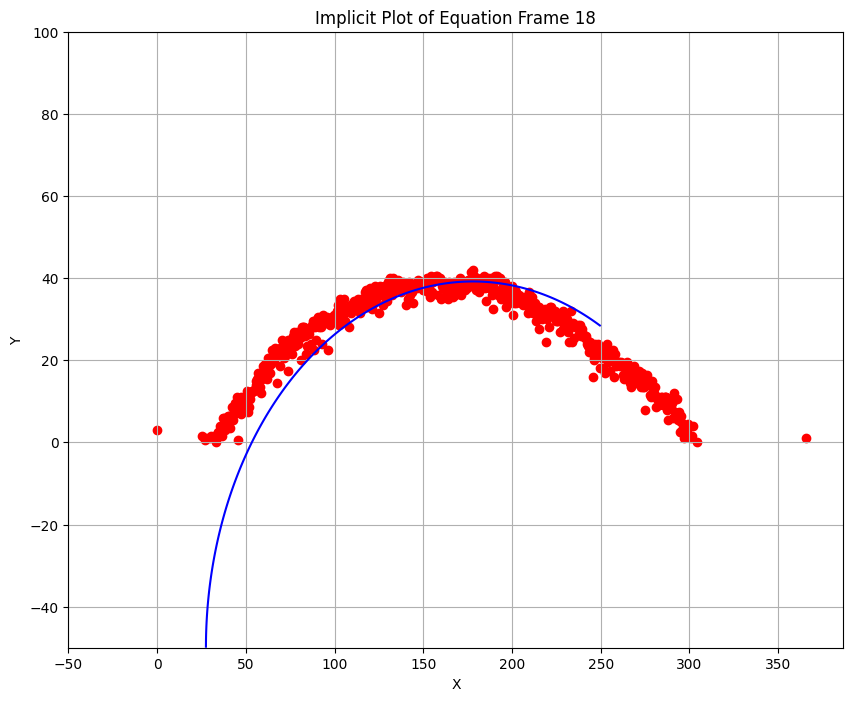

Optimal parameters: a=100.0, b=59.26768748431983, y_0=-50.0, C=-1.615488749005829, x_0=178.0
Angle: 41.6633348315164


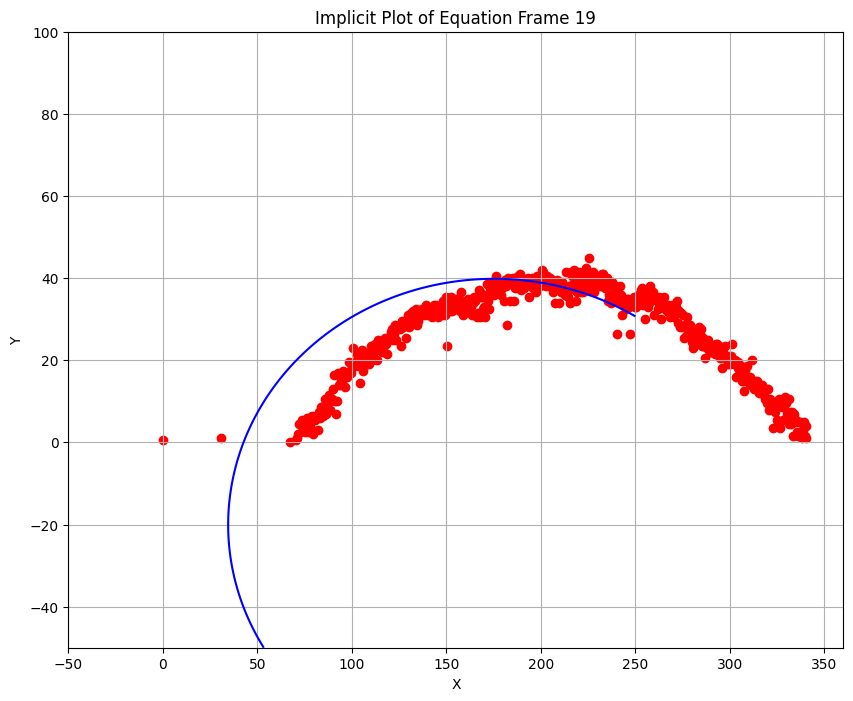

Optimal parameters: a=100.0, b=42.56072823738488, y_0=-20.064504536455864, C=-1.3130617830835432, x_0=175.25
Angle: 49.76536730115825


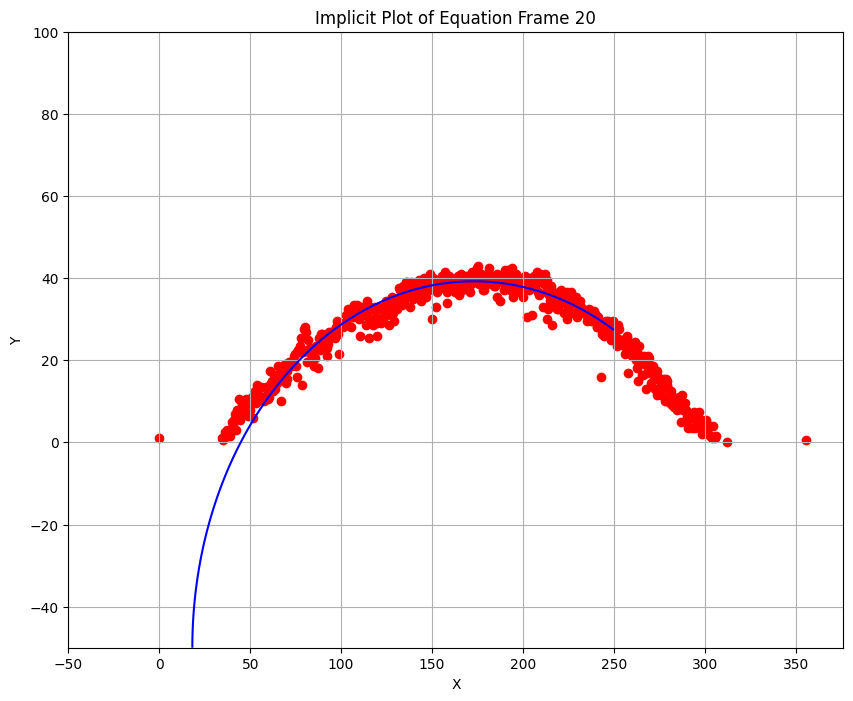

Optimal parameters: a=100.0, b=57.627850204251104, y_0=-50.0, C=-1.3484451642273736, x_0=173.0
Angle: 40.78846717606335


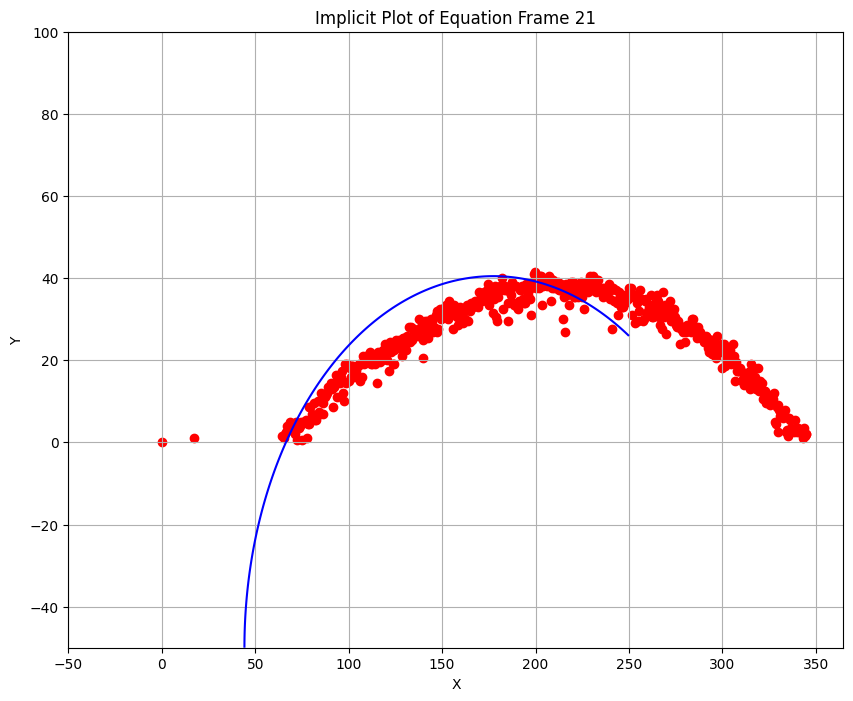

Optimal parameters: a=100.0, b=67.87881347612273, y_0=-50.0, C=-1.9163787631370166, x_0=177.5
Angle: 44.841631634157686


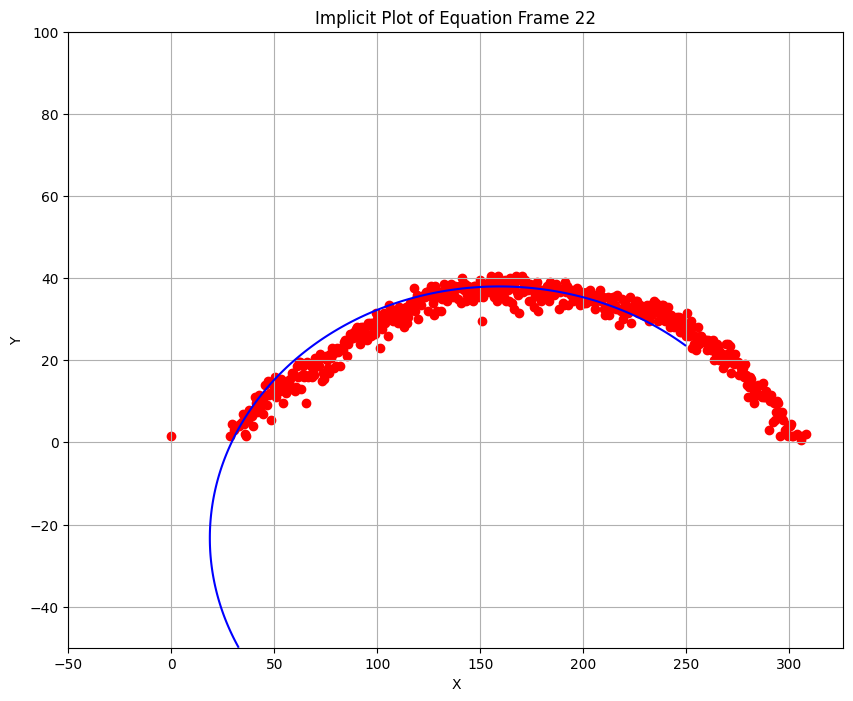

Optimal parameters: a=100.0, b=43.59521770782314, y_0=-23.30329386023007, C=-0.8461504649180924, x_0=159.25
Angle: 46.41408957471274


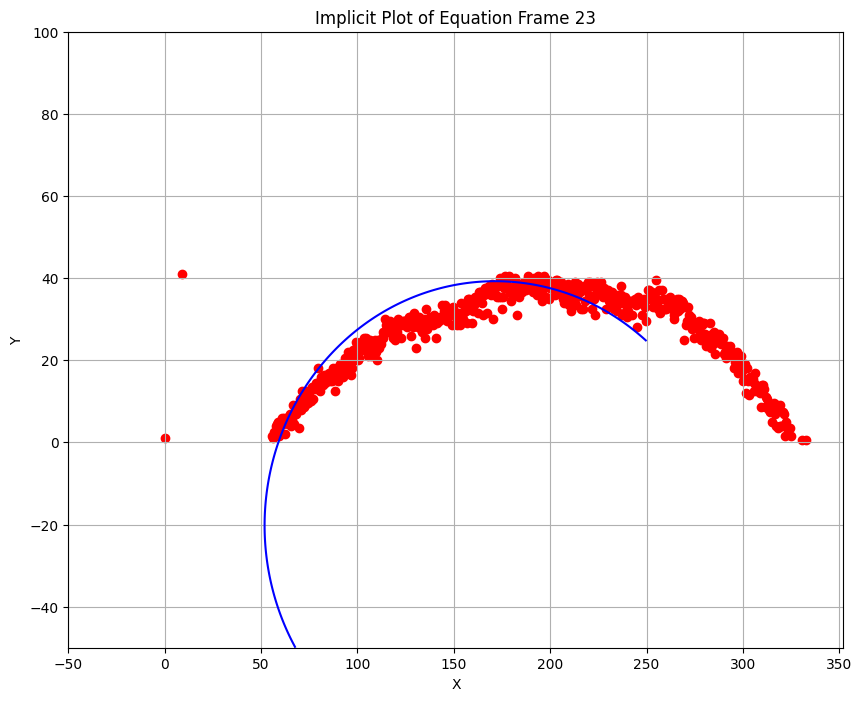

Optimal parameters: a=100.0, b=49.718984215547536, y_0=-20.25885869726558, C=-1.674457547234119, x_0=171.5
Angle: 53.25615600542698


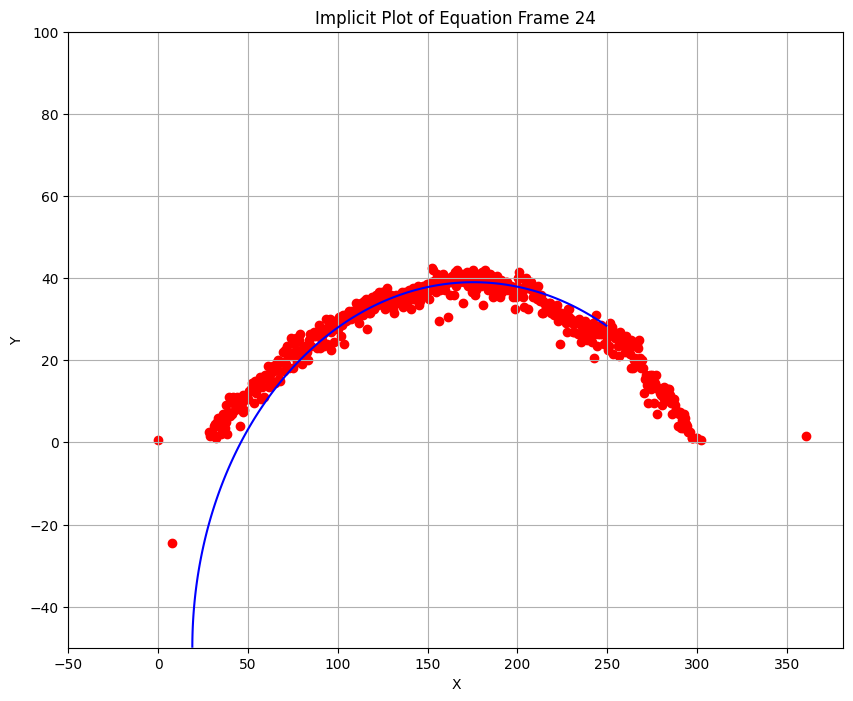

Optimal parameters: a=100.0, b=56.87504924002861, y_0=-50.0, C=-1.4037559580834091, x_0=175.5
Angle: 40.31859871277629


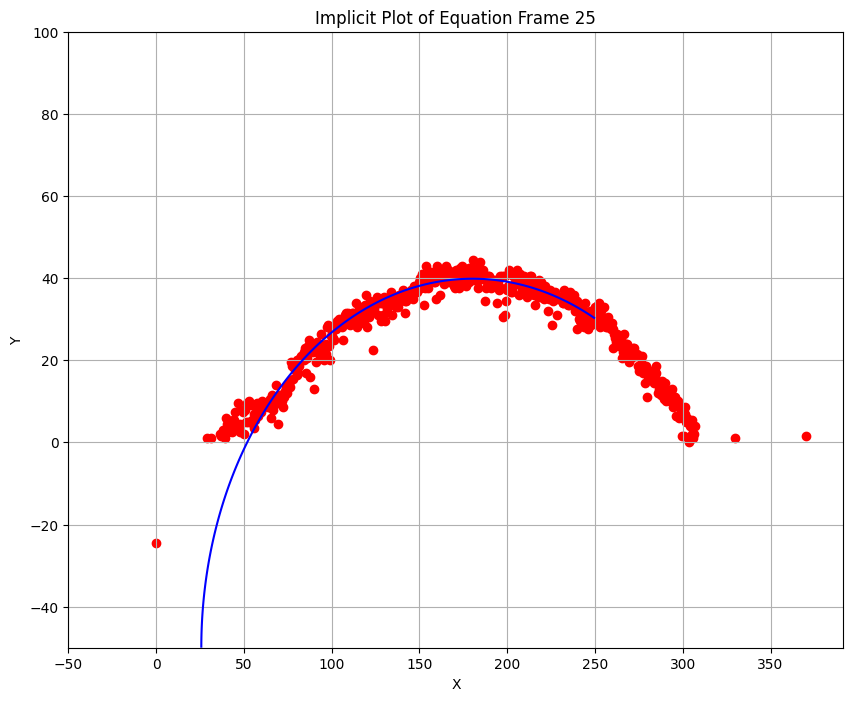

Optimal parameters: a=100.0, b=58.14612902423994, y_0=-50.0, C=-1.6003830978779876, x_0=180.25
Angle: 41.388834760802155


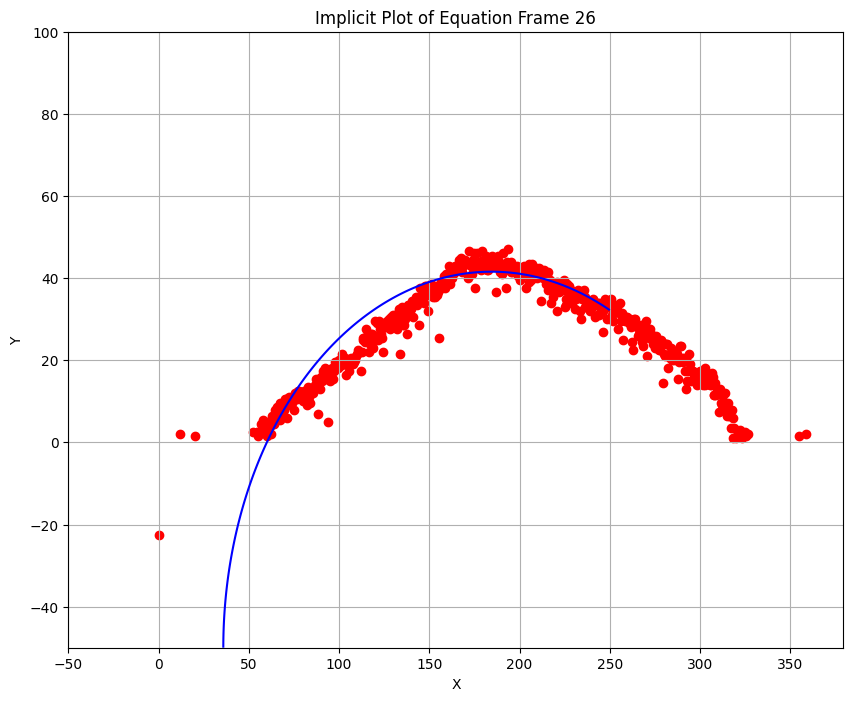

Optimal parameters: a=100.0, b=61.59214913974702, y_0=-50.0, C=-1.852914806085949, x_0=184.5
Angle: 42.79057979374785


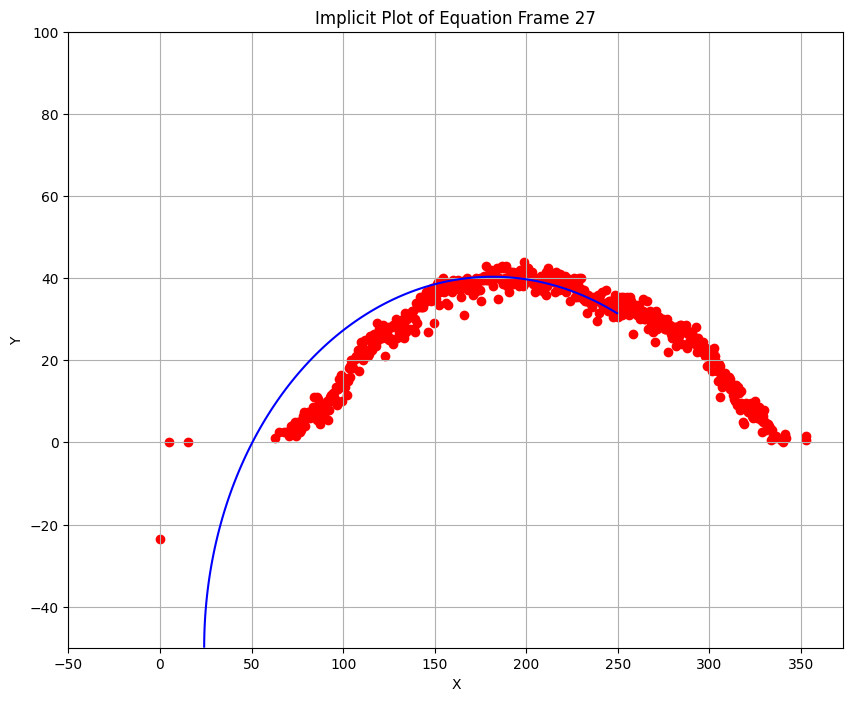

Optimal parameters: a=100.0, b=57.4030895308321, y_0=-50.0, C=-1.5764364543679703, x_0=181.5
Angle: 40.3796801000308


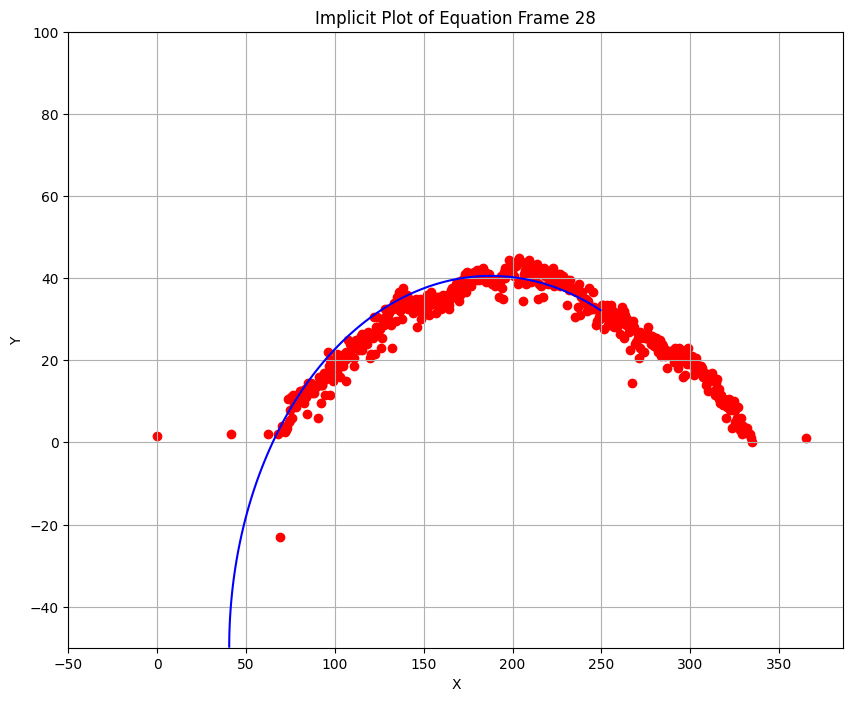

Optimal parameters: a=100.0, b=61.49628133965333, y_0=-50.0, C=-2.0184528920230616, x_0=187.75
Angle: 42.21546613641199


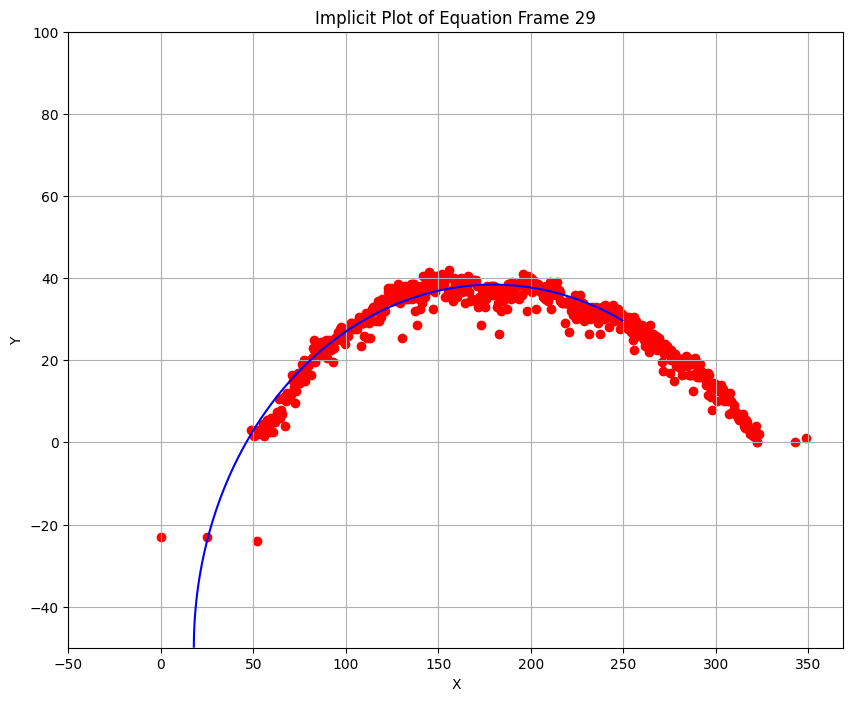

Optimal parameters: a=100.0, b=54.6780598501275, y_0=-50.0, C=-1.4437136925235572, x_0=179.5
Angle: 38.18665133259598


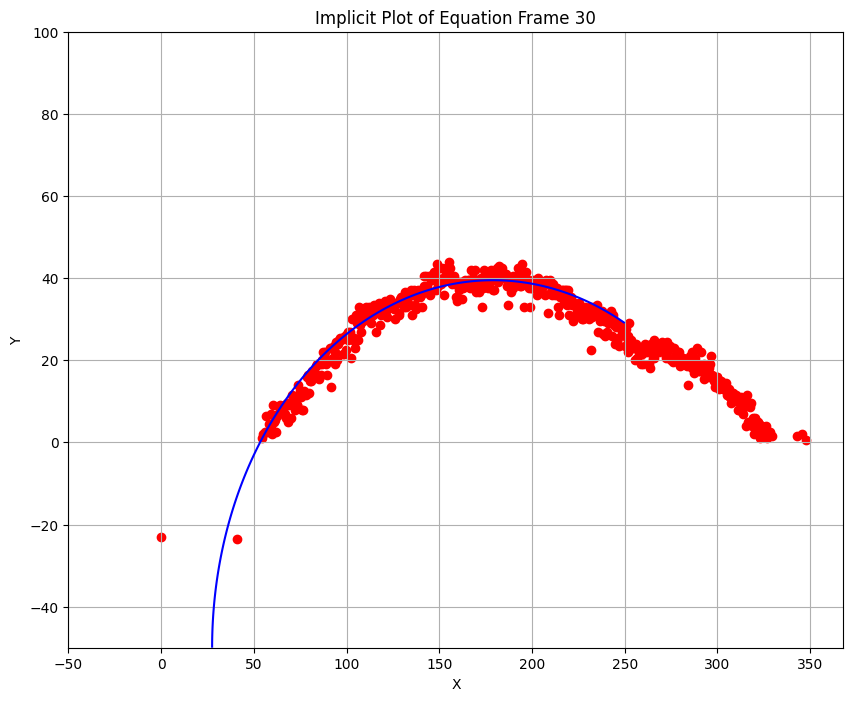

Optimal parameters: a=100.0, b=59.06959497634855, y_0=-50.0, C=-1.6251286787599206, x_0=179.0
Angle: 40.73898112691188


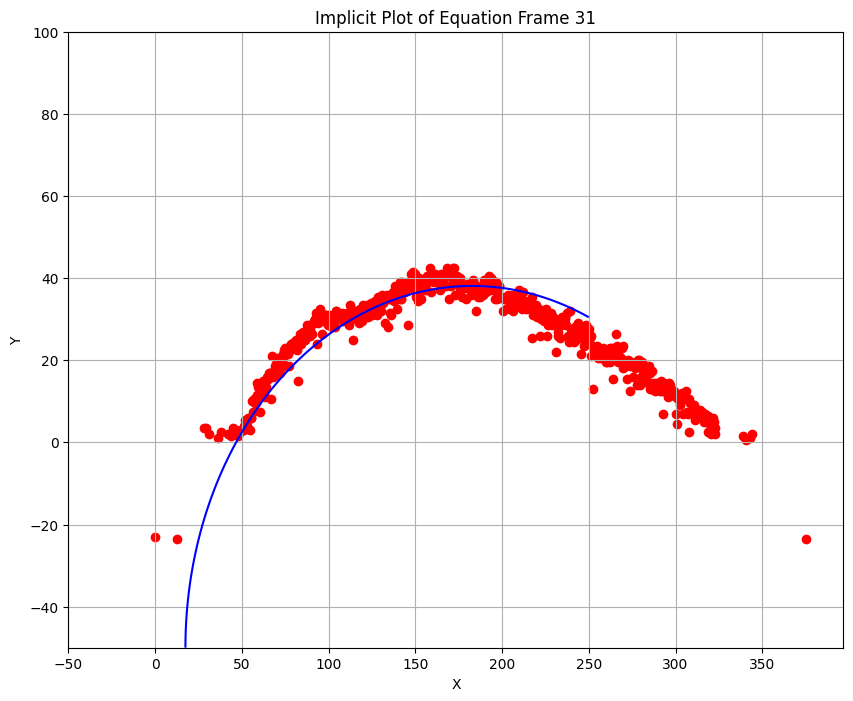

Optimal parameters: a=100.0, b=53.30049785235196, y_0=-50.0, C=-1.4879131472855671, x_0=182.75
Angle: 38.044879704939724


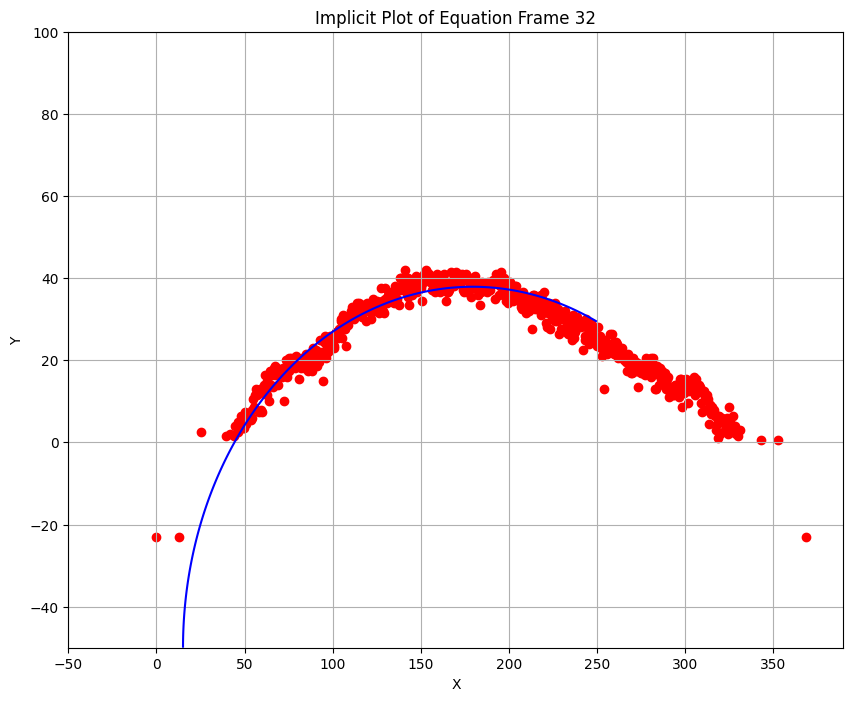

Optimal parameters: a=100.0, b=53.45417113714827, y_0=-50.0, C=-1.3929482746497697, x_0=179.5
Angle: 38.019775282460024


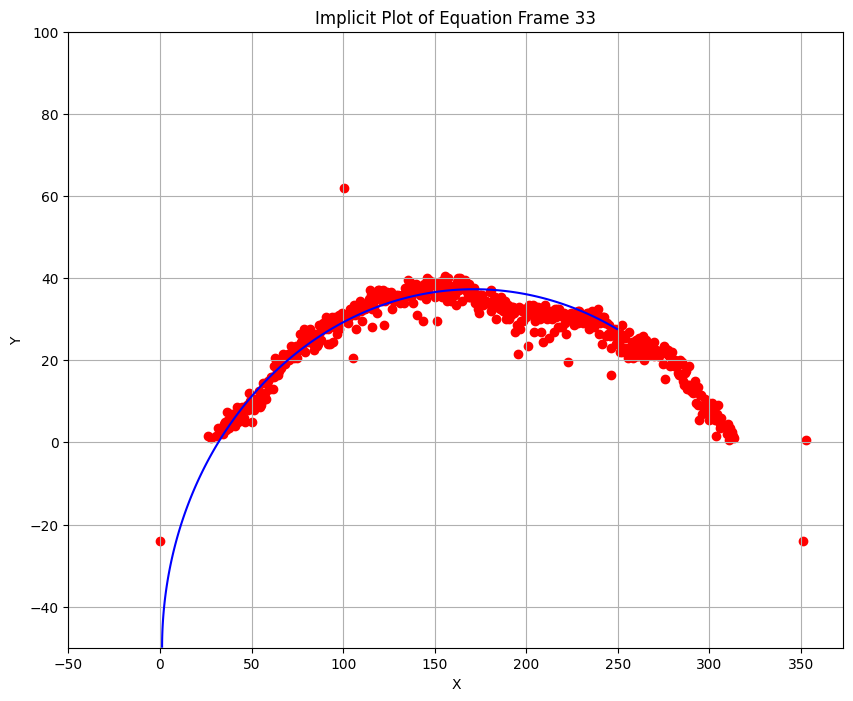

Optimal parameters: a=100.0, b=51.24424499436005, y_0=-50.0, C=-0.9911723761022823, x_0=171.5
Angle: 36.47053744205691


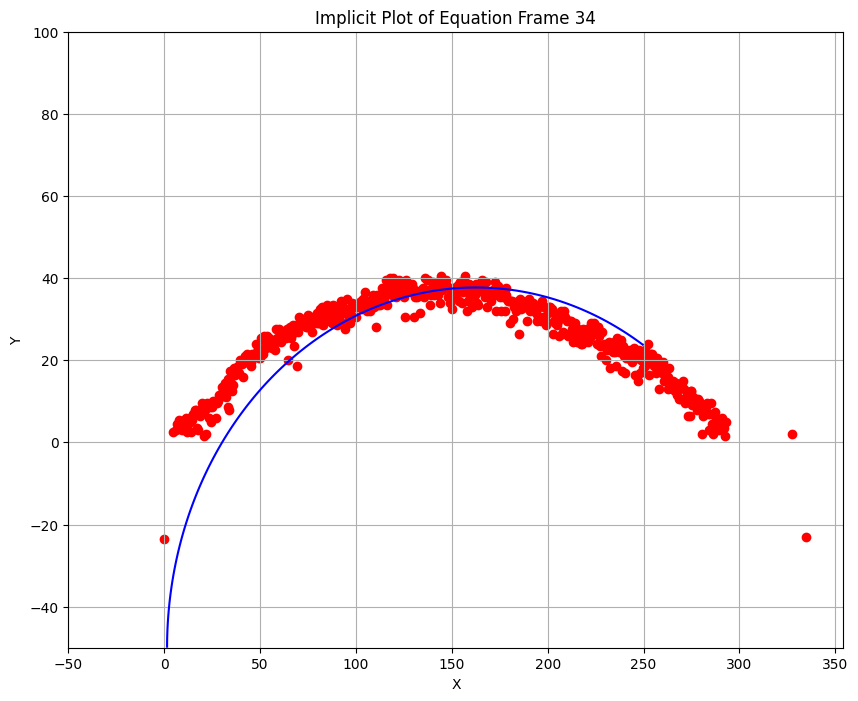

Optimal parameters: a=100.0, b=54.47490488818391, y_0=-50.0, C=-0.8898430847533668, x_0=162.5
Angle: 38.37228516100779


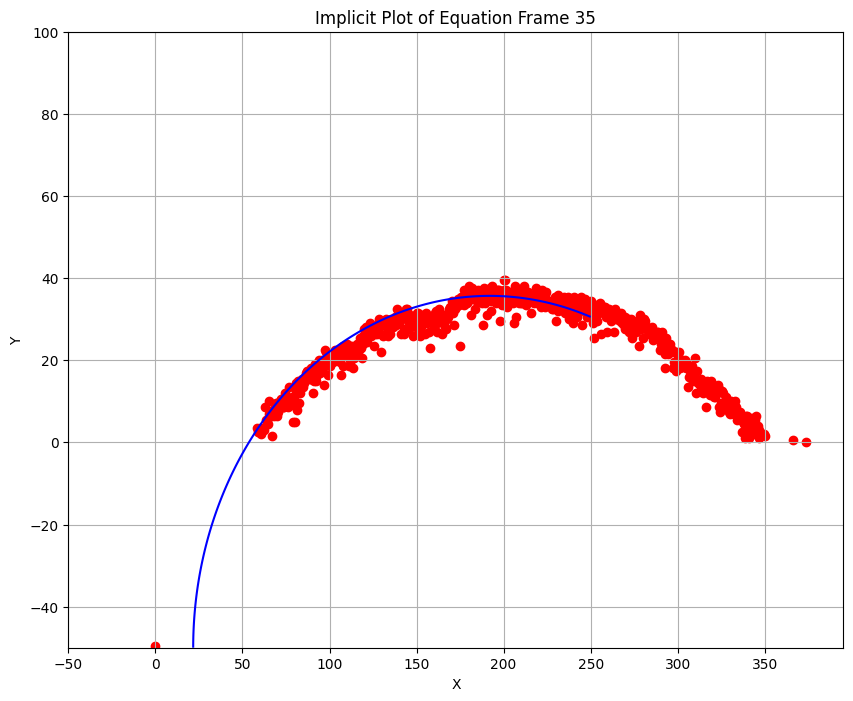

Optimal parameters: a=100.0, b=50.30600025182924, y_0=-50.0, C=-1.7735365559970788, x_0=192.0
Angle: 34.595984721429886


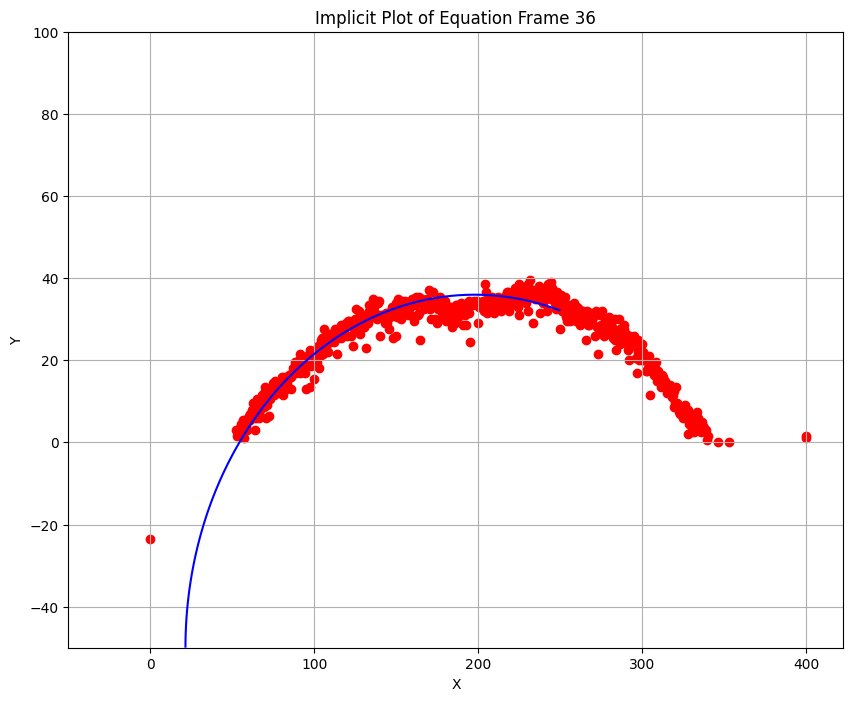

Optimal parameters: a=100.0, b=48.74982858660282, y_0=-50.0, C=-1.8511047600383044, x_0=197.69683622664874
Angle: 34.44286745410802


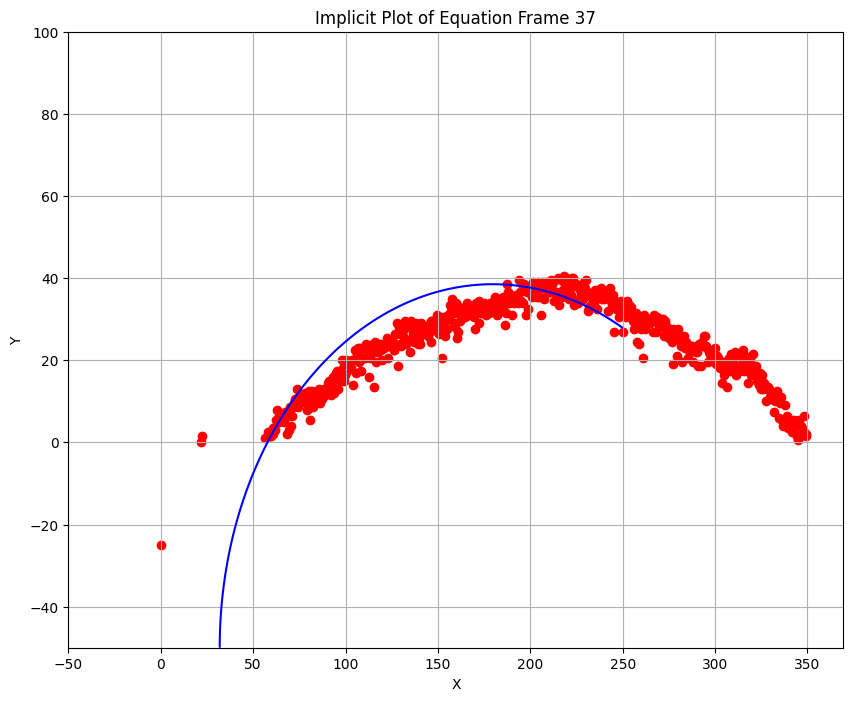

Optimal parameters: a=100.0, b=59.86731681884043, y_0=-50.0, C=-1.7425206457464015, x_0=179.75
Angle: 40.585500177961414


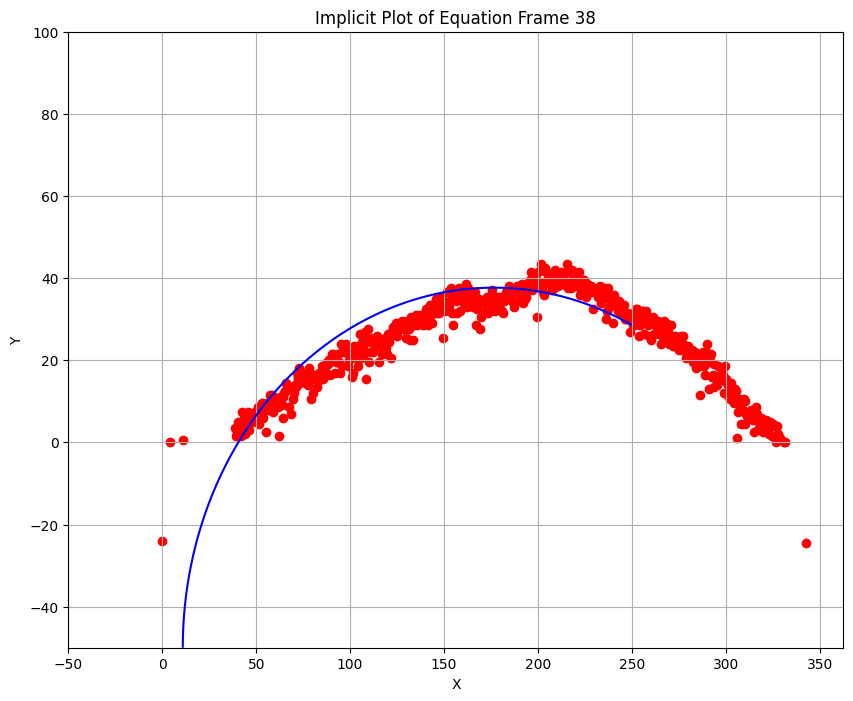

Optimal parameters: a=100.0, b=52.94376410258844, y_0=-50.0, C=-1.2648076484884514, x_0=176.5
Angle: 37.01215825419127


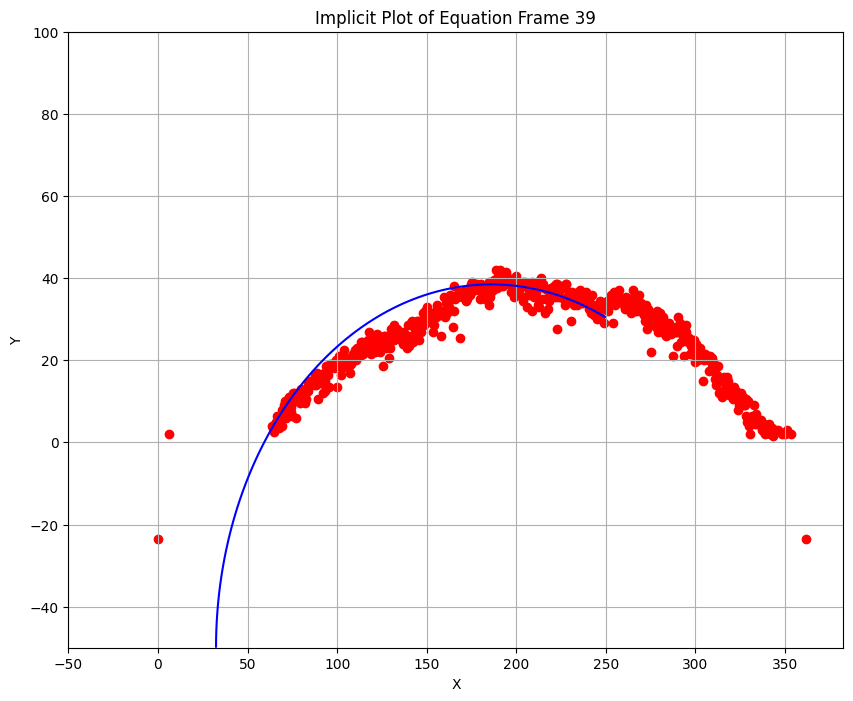

Optimal parameters: a=100.0, b=57.60074629536, y_0=-50.0, C=-1.854001946005322, x_0=186.0
Angle: 39.5054567989123


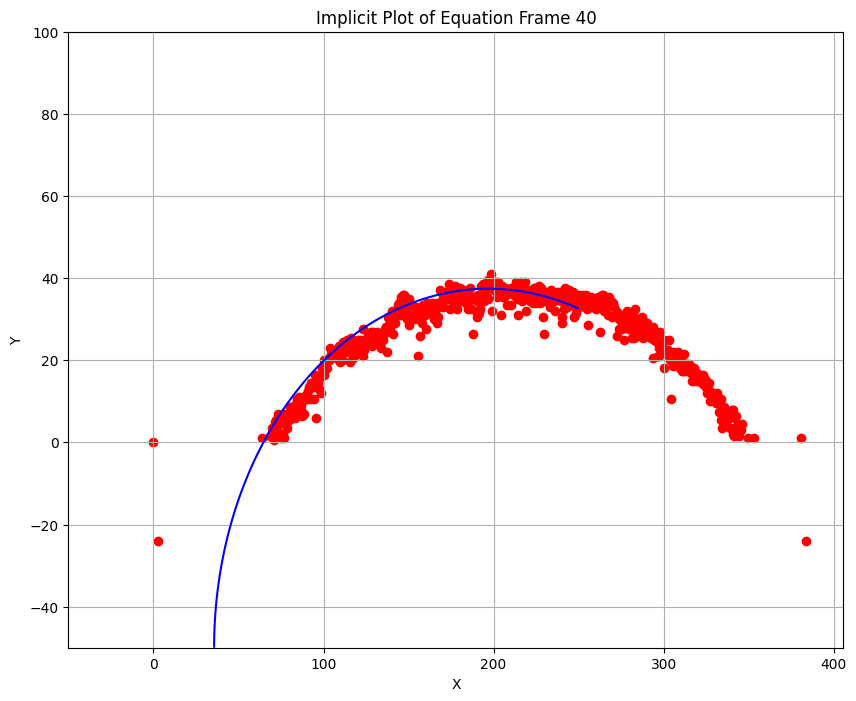

Optimal parameters: a=100.0, b=54.19042760535807, y_0=-50.0, C=-2.129693611900381, x_0=197.0
Angle: 37.31299295915717


In [66]:
frame_list = []
angle_list = []
x_0_list = []
ellipse_fit_error = 0

for frame in range(len(x_vals.keys())):
    
    X_data = np.array(x_vals[frame])  # X values
    Y_data = np.array(y_vals[frame])  # Y values
    
    x_0 = max(X_data) / 2  # Generally true statement 
    x_0_list.append(x_0)
    x_0_pm = 5

    # Initial guess for the parameters [a, b, y_0, C, x_0]
    initial_guess = [0.4, 0.5, -11.1, 10, x_0]

    # Define bounds for the parameters: (a, b, y_0, C, x_0)
    a_B = (0.1, 100)
    b_B = (0.1, 100)
    y_0_B = (-50, -20)
    C_B = (-100, 100)
    x_0_B = (x_0 - x_0_pm, x_0 + x_0_pm)
    
    bounds = [a_B, b_B, y_0_B, C_B, x_0_B] 

    # Perform the optimization
    result = minimize(objective, initial_guess, args=(X_data, Y_data), method='L-BFGS-B', bounds=bounds)

    # Extract the optimal parameters
    a_opt, b_opt, y_0_opt, C_opt, x_0_opt = result.x

    # Create a grid of points
    x = np.linspace(-50, 250, 400)
    y = np.linspace(-50, 100, 400)
    X, Y = np.meshgrid(x, y)
    Z = implicit_eq(X, Y, a_opt, b_opt, y_0_opt, C_opt, x_0_opt)

    # Plot the contour where Z = 0
    plt.figure(figsize=(10, 8))
    contour = plt.contour(X, Y, Z, levels=[0], colors='blue')
    plt.title(f'Implicit Plot of Equation Frame {frame}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.scatter(X_data, Y_data, color='red')  # Scatter plot of your data points

    subdirectory = r'C:\Users\jeffs\Downloads\SZvsWorkspaceUpper\SZvsWorkspace\Research\Project2WettingAngle\ProgramOutputs\fitting_methods'
    plot_path = os.path.join(subdirectory, f'best_fit_ellipse{frame}.png')
    #plt.savefig(plot_path)

    plt.show()

    for i in range(len(x_vals[frame])):
        ellipse_fit_error += np.abs((1/(a_opt**2))*X_data[i]**2 - (2*x_0_opt/(a_opt**2))*X_data[i] + (1/(b_opt**2))*Y_data[i]**2 - (2*y_0_opt)/(b_opt**2)*Y_data[i] - C_opt)

    # Angle calculation
    x_a = x_0_opt + math.sqrt(x_0**2 + C_opt * a_opt**2)
    dydx_x_a = b_opt**2*(x_0-x_a)/(a_opt**2*(-y_0_opt))
theta = abs(math.atan(dydx_x_a)) * 180 / math.pi

    # Creating x & y datas
    frame_list.append(frame)
    angle_list.append(theta)

    print(f"Optimal parameters: a={a_opt}, b={b_opt}, y_0={y_0_opt}, C={C_opt}, x_0={x_0_opt}")
    print(f'Angle: {theta}')